In this notebook we will implement recommendation system based on Slope-One and SVD algorithms

The original paper of [Slope-one](https://arxiv.org/abs/cs/0702144) algorithm

We will explore [Movielens 100k dataset](https://grouplens.org/datasets/movielens/100k/) and compare the accuracy rate of the recommendation system built with 2 techiques:
1. The only Slop-One
2. SVD (low rank approximation) + Slope-One on the reduced matrix (The idea is taken from [this](https://www.atlantis-press.com/proceedings/mcei-15/25840929) paper)

## 1. Data vizualization

MovieLens data sets were collected by the GroupLens Research Project
at the University of Minnesota.
 
This data set consists of:
	* 100,000 ratings (1-5) from 943 users on 1682 movies. 
	* Each user has rated at least 20 movies. 
    * Simple demographic info for the users (age, gender, occupation, zip) (it is not used in our project)
    
- `ua.base` and `ua.test`   - are datasets the were obtained by split the `u.data` file into a training set and a test set with exactly 10 ratings per user in the test set.

In [1]:
import pandas as pd
import numpy as np
import sys

data = pd.read_csv('ml-100k/u.data', sep = '\t', names = ['user id', 'item id', 'rating', 'timestamp'])
data.drop('timestamp', axis = 1, inplace = True)

### Distribution of ratings

In [26]:
import matplotlib.pyplot as plt
from plotly.offline import init_notebook_mode, plot, iplot
import plotly.graph_objs as go
init_notebook_mode(connected=True)
%matplotlib inline

df = data['rating'].value_counts().sort_index(ascending=False)
trace = go.Bar(x = df.index,
               text = ['{:.1f} %'.format(val) for val in (df.values / data.shape[0] * 100)],
               textposition = 'auto',
               textfont = dict(color = '#000000'),
               y = df.values,
               )
# Create layout
layout = dict(title = 'Distribution of {} film-ratings'.format(data.shape[0]),
              xaxis = dict(title = 'Rating'),
              yaxis = dict(title = 'Count'))
# Create plot
fig = go.Figure(data=[trace], layout=layout)
iplot(fig,show_link = True,auto_play = True)

#### Almost all films got rating $3$, $4$ and $5$

### Histogram of Number of Ratings Per Film

In [3]:
df = data.groupby('item id')['rating'].count().clip(upper = 100) # number of ratings per film if >100 then = 100

trace = go.Histogram(x = df.values,
                     name = 'Ratings',
                     xbins = dict(start = 0,
                                  end = 100,
                                  size = 2))

layout = go.Layout(title = 'Histogram of Number of Ratings Per Film ',
                   xaxis = dict(title = 'Number of Ratings per Film'),
                   yaxis = dict(title = 'Quantity of Films'),
                   bargap = 0.2)

fig = go.Figure(data=[trace], layout=layout)
iplot(fig,show_link = True)

#### The distribution is not normal. Most of films got just 1 rating

### Histogram of Number of Ratings Per User

In [4]:
df = data.groupby('user id')['rating'].count().clip(upper=50) # number of ratings which one user gave

# Create trace
trace = go.Histogram(x = df.values,
                     name = 'Ratings',
                     xbins = dict(start = 0,
                                  end = 50,
                                  size = 2))
# Create layout
layout = go.Layout(title = 'Histogram of Number of Ratings per User (Clipped at 50)',
                   xaxis = dict(title = 'Number of Ratings given by user'),
                   yaxis = dict(title = 'Quantity of users'),
                   bargap = 0.2)

# Create plot
fig = go.Figure(data=[trace], layout=layout)
iplot(fig,show_link = True)

In [5]:
data = pd.read_csv('ml-100k/u.data', sep = '\t', names = ['user id', 'item id', 'rating', 'timestamp'])
data.drop('timestamp', axis = 1, inplace = True)

trace = go.Scatter3d(
    x = data['user id'][:200],  
    y = data['item id'][:200],  
    z = data['rating'][:200],  
    mode='markers',
    marker={
        'size': 5,
        'opacity': 0.8,
        'color' : data['rating'][:200],                
        'colorscale' : 'Viridis'
    }
)

layout = go.Layout(
    margin={'l': 0, 'r': 0, 'b': 0, 't': 0} 
)

df = [trace]

fig = go.Figure(data=df, layout=layout)


fig.update_layout(scene = dict(
                    xaxis_title='User',
                    yaxis_title='Movie',
                    zaxis_title='Rating'),
                    width=700,
                    margin=dict(r=20, b=10, l=10, t=10))

iplot(fig,show_link = True)

## 2. Data preprocessing

In [2]:
data = pd.read_csv('ml-100k/u.data', sep = '\t', names = ['user id', 'item id', 'rating', 'timestamp'])
df_base = pd.read_csv('ml-100k/ua.base',  sep='\t', names = ['user id', 'item id', 'rating', 'timestamp'])
df_test = pd.read_csv('ml-100k/ua.test', sep='\t', names = ['user id', 'item id', 'rating', 'timestamp'])

df_base.drop('timestamp', axis = 1, inplace = True)
df_test.drop('timestamp', axis = 1, inplace = True)
data.drop('timestamp', axis = 1, inplace = True)

print('whole data:', data.shape)
print('train data:', df_base.shape)
print('test data:', df_test.shape)

whole data: (100000, 3)
train data: (90570, 3)
test data: (9430, 3)


In [3]:
df_base.head(10)

,user id,item id,rating
0,1,1,5
1,1,2,3
2,1,3,4
3,1,4,3
4,1,5,3
5,1,6,5
6,1,7,4
7,1,8,1
8,1,9,5
9,1,10,3


#### Transform dataset into User-Item matrix

In [4]:
USER_NUM = 943
ITEM_NUM = 1682

def trans_to_mat(df):
    matrix = np.zeros((USER_NUM, ITEM_NUM))
    for i, data in df.iterrows():
        matrix[data[0] - 1][data[1] - 1] = data[2]
    return matrix

data.sort_values(by=['user id'])
data_mat = trans_to_mat(data)
base_mat = trans_to_mat(df_base)
test_mat = trans_to_mat(df_test)

print('whole data:', data.shape)
print('train data:', base_mat.shape)
print('test data:', test_mat.shape)

whole data: (100000, 3)
train data: (943, 1682)
test data: (943, 1682)


#### User-Item matrix

In [5]:
base_mat

array([[5., 3., 4., ..., 0., 0., 0.],
       [4., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [5., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 5., 0., ..., 0., 0., 0.]])

#### Matrix density

In [6]:
print('Density of matrix is:', round(np.count_nonzero(base_mat)/(base_mat.shape[0] * base_mat.shape[1]),3))

Density of matrix is: 0.057


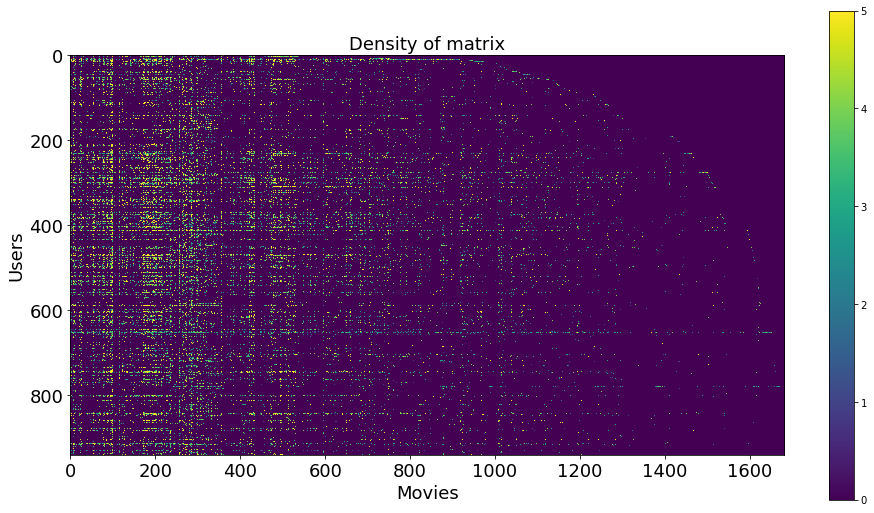

In [16]:
plt.figure(figsize = (16,9))
plt.title('Density of matrix', fontsize = 18)

plt.imshow(base_mat)
plt.colorbar()
plt.xlabel('Movies', fontsize = 18)
plt.ylabel('Users', fontsize = 18)

plt.xticks(fontsize=18)
plt.yticks(fontsize=18)
plt.show()

/Users/alexander/anaconda3/lib/python3.7/site-packages/seaborn/distributions.py:679: UserWarning:

Passing a 2D dataset for a bivariate plot is deprecated in favor of kdeplot(x, y), and it will cause an error in future versions. Please update your code.



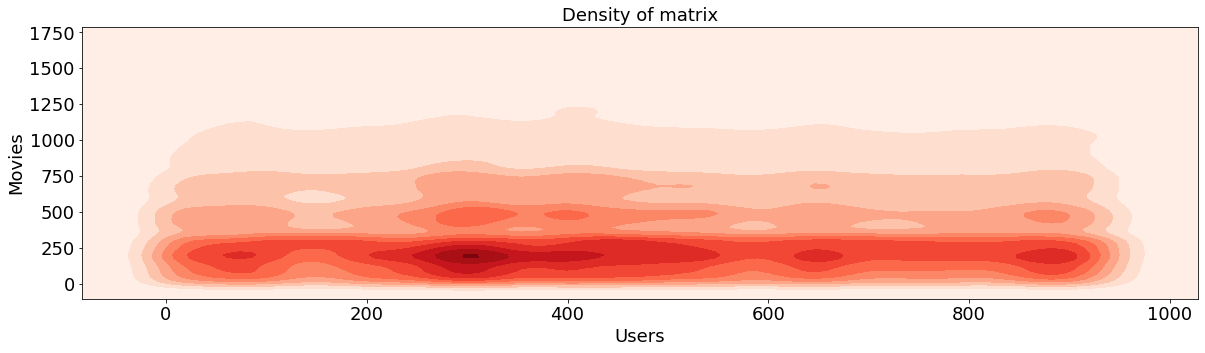

In [17]:
import seaborn as sns
plt.figure(figsize=(20,5))
plt.title('Density of matrix', fontsize = 18)
sns.kdeplot(data = data, cmap="Reds", shade=True) # it may take a while to run
plt.xlabel('Users', fontsize = 18)
plt.ylabel('Movies', fontsize = 18)

plt.xticks(fontsize=18)
plt.yticks(fontsize=18)
plt.show()

### With the help of last two graphs we are able to lessen the time of execution of our code by simple checks. We can see that movies to the end are not rated

#### Next 3 cells can help to understand how train and test data looks like

In [26]:
base_mat[0][:100]

array([5., 3., 4., 3., 3., 5., 4., 1., 5., 3., 2., 5., 5., 5., 5., 5., 3.,
       4., 5., 0., 1., 4., 4., 3., 4., 3., 2., 4., 1., 3., 3., 5., 0., 2.,
       1., 2., 2., 3., 4., 3., 2., 5., 4., 5., 5., 4., 4., 5., 3., 5., 4.,
       4., 3., 3., 5., 4., 5., 4., 5., 5., 0., 3., 2., 5., 4., 4., 3., 4.,
       3., 3., 3., 4., 3., 1., 4., 4., 4., 1., 4., 4., 5., 5., 3., 4., 3.,
       5., 5., 4., 5., 4., 5., 3., 5., 2., 4., 5., 3., 4., 3., 5.])

In [27]:
test_mat[0][:100]

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 4., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 4., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 4., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])

In [28]:
data_mat[0][:100]

array([5., 3., 4., 3., 3., 5., 4., 1., 5., 3., 2., 5., 5., 5., 5., 5., 3.,
       4., 5., 4., 1., 4., 4., 3., 4., 3., 2., 4., 1., 3., 3., 5., 4., 2.,
       1., 2., 2., 3., 4., 3., 2., 5., 4., 5., 5., 4., 4., 5., 3., 5., 4.,
       4., 3., 3., 5., 4., 5., 4., 5., 5., 4., 3., 2., 5., 4., 4., 3., 4.,
       3., 3., 3., 4., 3., 1., 4., 4., 4., 1., 4., 4., 5., 5., 3., 4., 3.,
       5., 5., 4., 5., 4., 5., 3., 5., 2., 4., 5., 3., 4., 3., 5.])

#### We see that base_mat and test_mat are compound of data indeed

### Let us consider the rank of  user-item matrix 

In [18]:
from numpy.linalg import matrix_rank

print('The rank of matrix is :', matrix_rank(base_mat))
print('The size of matrix is :', base_mat.shape)

The rank of matrix is : 943
The size of matrix is : (943, 1682)


#### It is full-rank matrix!! And actually it was predictable, because user-item matrix is a sparse one.

Identity matrices of big sizes are full-rank and sparse as well.

## 3. Slope-One

#### Notations:

- $u$ - the ratings of all the watched films given by the user (np.array - row of the main matrix)
- $S(u)$ - the set of items which have the rating value in $u$ row
- $\chi$ -  the set of all evaluations in the training set
- $card(S)$ -  the number of elements in a set $S$ 
- $S_i(\chi)$ - the set of all evaluations $u \in \chi$ whivh contain item $i$ (non-zero)rating

In this project we implement weighted Slope-one Scheme

Given a training set $\chi$, and any two items $j$ and $i$ with ratings $u_j$ and $u_i$ respectively in some user evaluation $u$ (annotated as $u \in S_{ji}(\chi)$),  the average deviation of item $i$ with respect to item $j$ is:

$$dev_{ij} = \sum_{u \in S_{ji}(\chi)} \dfrac{u_j-u_i}{card(S_{ji}(\chi))}$$

Then, we define the WEIGHTED SLOPE ONE prediction as the following weighted average

$$P(u)_j^{weighted} = \dfrac{\sum_{i \in S(u)-j} (dev_{ji}+u_i)c_{ji}}{\sum_{i \in S(u)-j}c_{ji}}$$

where $c_{ji} = card(S_{ji}(\chi))$

In [30]:
import os

def weighted_slope_one(input_mat, test_mat):
    user_num = input_mat.shape[0]
    item_num = input_mat.shape[1]
    
    def get_deviation(i, j):
        """
        function calculates deviation of items i and j
        @param item pair
        @return average deviation value and nb of users who evaluated both movies i & j
        """
        dev_ij = 0
        users = 0 # nb of users who evaluated both movies i & j
        for row in range(user_num):
            # if the user evaluated both movie i and movie j
            if (input_mat[row][i] != 0) and (input_mat[row][j] != 0):  # trouble
                users += 1
                dev_ij += input_mat[row][i] - input_mat[row][j]
        
        # avoid zero division
        if(users == 0):
            deviation = 0
        else:
            deviation = dev_ij / users
        return deviation, users

    dev = np.zeros((item_num, item_num)) # average deviation matrix
    evaled_users_mat = np.zeros((item_num, item_num)) # matrix of card(S_{ji})  
    
    for i in range(item_num):
        for j in range(item_num):
            if i == j:
                # to lessen the time complexity
                break
            else:
                dev_temp, users = get_deviation(i, j)
                dev[i][j] = dev_temp
                dev[j][i] = (-1) * dev_temp
                evaled_users_mat[i][j] = users
                evaled_users_mat[j][i] = users
    
    # get the prediction matrix
    pred_mat = np.zeros((user_num, item_num))
    for user in range(user_num):
        eval_row = np.where(input_mat[user] != 0)[0] # indices of items rating unequal to 0 in row u 
        
        for j in range(item_num):
            if test_mat[user][j] == 0:
                continue
            numerator = np.sum((dev[j][eval_row] + input_mat[user][eval_row]) * evaled_users_mat[j][eval_row])
            denominator = np.sum(evaled_users_mat[j][eval_row])
            
            pred_mat[user][j] = (numerator / denominator) if denominator != 0 else 0
    
    # save to csv
    dir_ = 'output_data111'
    if not os.path.exists(dir_):
        os.makedirs(dir_)
    pd.DataFrame(pred_mat).to_csv(f'{dir_}/pred_mat_only_slope1.csv', index=False)
    
    return pred_mat

In [7]:
from math import isnan,ceil,floor

# the function makes predictions integer and make them bounded by 0 and 5 
def predict_correction(elem): 
    if isnan(elem):
        return 0
    elif elem > 5:
        return 5
    elif elem < 0:
        return 0
    
    elif elem-int(elem) >= 0.5:
        return ceil(elem)
    else:
        return floor(elem)


# predict = weighted_slope_one(base_mat) # run this in case you want calculate once again - may take a while

predict = pd.read_csv('output_data/pred_mat_only_slope1.csv')
predict = np.array(predict)

# make predictions integer and vast from 0 to 5
vfunc = np.vectorize(predict_correction)
predict = vfunc(predict)
predict

array([[4, 3, 3, ..., 2, 3, 3],
       [4, 3, 3, ..., 2, 4, 4],
       [3, 3, 2, ..., 2, 3, 2],
       ...,
       [4, 3, 3, ..., 2, 3, 3],
       [4, 4, 4, ..., 2, 4, 4],
       [4, 3, 3, ..., 0, 3, 3]])

## 4. Measure the errors

#### In accordance with the [article](https://www.atlantis-press.com/proceedings/mcei-15/25840929) we measure errors through RMSE and MAE 

In [8]:
import math

def RMSE(predict, correct):
    pred = predict[np.where((correct > 0) & (~np.isnan(predict)))]
    cor = correct[np.where((correct > 0) & (~np.isnan(predict)))]
    return math.sqrt(np.average((pred - cor) ** 2))

def MAE(predict, correct):
    pred = predict[np.where((correct > 0) & (~np.isnan(predict)))]
    cor = correct[np.where((correct > 0) & (~np.isnan(predict)))]
    return np.average(np.abs(pred - cor))

In [9]:
print('RMSE:', round(RMSE(predict, test_mat), 3))
print('MAE:', round(MAE(predict, test_mat), 3))

RMSE: 1.001
MAE: 0.719


The error rate is rather small! Not more than point. We see that the algorithm works indeed!

## We wanted to implement accuracy or F1 score, but they are not so representative in our case

In [52]:
from sklearn.metrics import accuracy_score

def acc(predict, correct):
    
    pred = predict[np.where((correct > 0) & (~np.isnan(predict)))]
    cor = correct[np.where((correct > 0) & (~np.isnan(predict)))]
    
    predict = np.ravel(pred)
    correct = np.ravel(cor)
    
    return accuracy_score(predict, correct)

print('Accuracy:', round(acc(predict, test_mat), 3))

Accuracy: 0.407


##### * supose for user A we got next array of rating [1,2,3,4,5] and the test matrix for him is [2,3,4,4] (it is really close), but accuracy will give us 0

##### it is better to use metrics which compute distance between each rating and take "mean"

## 5. SVD + Slope-One 

We considered next pipeline:

1. Replace all the missing values in user-item matrix with items averages. 
2. Normalize matrix by subtracting users averages (calculated based on initial rating matrix, not filled-in).
3. Perform Singular Value Decomposition of modified user-item matrix. 
    * It is bad to perform SVD on primary user-item matrix, because  we will get $U \cdot S \cdot V$ matrix and this matrix will contain numbers which cannot be interpreted as ratings.
    
    
4. Keeping only first r rows of matrix U, r rows and r columns of matrix S and r columns of matrix V.
    And then reconstruct matrix R: $U_{[:r,:]} \cdot S_{[:r,:r]} \cdot V_{[:,:r]}$.
    
5. Apply Slope-One algorithm to obtained modified user-item matrix R.

### SVD

#### Let's try with rank = 300. We will explain why it is good further.

In [57]:
mask = np.array(base_mat == 0)

masked_arr = np.ma.masked_array(base_mat, mask)
item_means = np.mean(masked_arr, axis=0)

utilMat = masked_arr.filled(item_means)
x = np.tile(item_means, (utilMat.shape[0],1))

utilMat = utilMat - x

In [58]:
rank = 300

U, sigma, V = np.linalg.svd(utilMat, full_matrices=False)


s1 = np.diag(sigma)
s1 = s[:rank,:rank]
U1 = U[:,:rank]
V1 = V[:rank,:]


Us = np.dot(U1,s1)
UsV = np.dot(Us,V1)
UsV = UsV + x

UsV.data

array([[5.0766281 , 3.05483071, 4.1175441 , ..., 2.        , 3.        ,
        3.        ],
       [4.07374317, 3.09126157, 3.1336082 , ..., 2.        , 3.        ,
        3.        ],
       [3.79750434, 3.14473145, 2.90249777, ..., 2.        , 3.        ,
        3.        ],
       ...,
       [4.81893895, 3.2008462 , 3.07085727, ..., 2.        , 3.        ,
        3.        ],
       [3.87369629, 3.17550144, 3.14350156, ..., 2.        , 3.        ,
        3.        ],
       [3.89154996, 4.95508392, 3.04165514, ..., 2.        , 3.        ,
        3.        ]])

#### Rounding SVD result

In [59]:
from math import ceil,floor

def myfunc(elem):
    if elem-int(elem) >= 0.5:
        return ceil(elem)
    else:
        return floor(elem)

roundfunc = np.vectorize(myfunc)
SVD_applied_pred_mat = roundfunc(UsV.data)
SVD_applied_pred_mat

array([[5, 3, 4, ..., 2, 3, 3],
       [4, 3, 3, ..., 2, 3, 3],
       [4, 3, 3, ..., 2, 3, 3],
       ...,
       [5, 3, 3, ..., 2, 3, 3],
       [4, 3, 3, ..., 2, 3, 3],
       [4, 5, 3, ..., 2, 3, 3]])

In [60]:
print('RMSE with only SVD:', round(RMSE(SVD_applied_pred_mat, test_mat), 3))
print('MAE with only SVD:', round(MAE(SVD_applied_pred_mat, test_mat), 3))

RMSE with only SVD: 1.071
MAE with only SVD: 0.799


### Slope one

In [ ]:
predict_svd_slope_one = weighted_slope_one(SVD_applied_pred_mat)

In [ ]:
predict_svd_slope_one = np.array(predict_svd_slope_one)

predict_svd_slope_one = vfunc(predict_svd_slope_one)
predict_svd_slope_one

## Now let's look on all possible ranks and apply our whole pipeline

### Decay of singular values of User-Item matrix

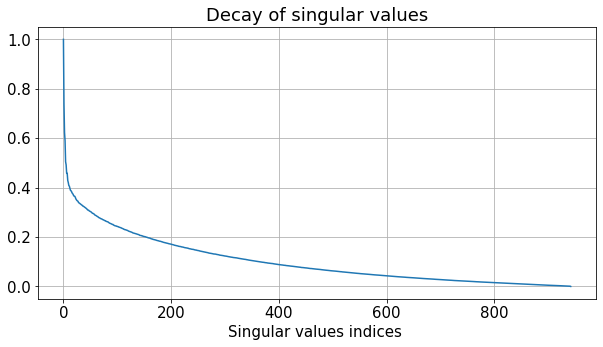

In [61]:
plt.figure(figsize = [10, 5])
plt.title('Decay of singular values', fontsize = 18)
plt.plot(sigma / sigma[0])
plt.xlabel("Singular values indices ", fontsize=15)
plt.yticks(fontsize=15)
plt.xticks(fontsize=15)
plt.grid(True)
plt.show()

In [5]:
# turn the flag into True if you want to calculate the errors on your own. Takes much time!!
flag_calc_SVD_approx = False

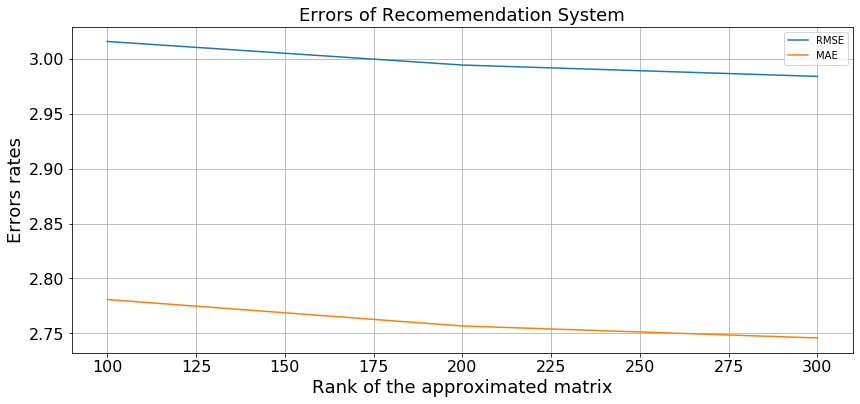

In [7]:
import json
from scipy.sparse.linalg import svds
from scipy.linalg import svd
import matplotlib.pyplot as plt

ranks = [300, 200, 100]

if flag_calc_SVD_approx:
    
    rmse = []
    mae = []
    for rank in ranks:
        
        u1 = U[:, :rank]
        s1 = s[:rank]
        v1 = V[:rank, :]


        Us = np.dot(U,s)
        UsV = np.dot(Us,V)
        UsV = UsV + x

        UsV = UsV.data

        SVD_applied_pred_mat = roundfunc(UsV)

        predict = weighted_slope_one(SVD_applied_pred_mat, test_mat)

        predict = vfunc(predict)

        rmse.append(RMSE(predict, test_mat))
        mae.append(MAE(predict, test_mat))
        ranks.append(rank)
    
        # just for safety
        with open('output_data/RMSE.txt', 'w') as outfile:
            json.dump(rmse, outfile)
        with open('output_data/MAE.txt', 'w') as outfile:
            json.dump(mae, outfile)
            
else:
    with open('output_data/RMSE.txt') as infile:
        rmse = json.load(infile)
    with open('output_data/MAE.txt') as infile:
        mae = json.load(infile)

plt.figure(figsize=(14,6))
plt.title('Errors of Recomemendation System',fontsize = 18)
plt.plot(ranks, rmse, label='RMSE')
plt.plot(ranks, mae, label='MAE')
plt.xlabel('Rank of the approximated matrix', fontsize=18)
plt.ylabel('Errors rates', fontsize=18)
plt.yticks(fontsize=16)
plt.xticks(fontsize=16)
plt.legend(loc='best')
plt.grid(True)
plt.show()

We tried several ranks but the best scores were obtained out of this 3 attempts. We decided to retain an amount of singular values to preserve 90% of the energy in $\sum \sigma_i^2$. That is, the sum of the squares of the retained singular values should be at least 90% of the sum of the squares of all the singular values.

In [43]:
percentage = np.linalg.norm(sigma[:300], 2) / np.linalg.norm(sigma, 2)

print('percentage:', int(percentage*100), '%')

percentage: 94 %


We see that $rank=300$ is a perfect choice

In [8]:
print('RMSE with SVD:', [round(elem, 3) for elem in rmse])
print('MAE with SVD:', [round(elem, 3) for elem in mae])

RMSE with SVD: [2.984, 2.994, 3.016]
MAE with SVD: [2.746, 2.757, 2.781]


Unfortunately we obtained results opposite to those in the [paper](https://www.atlantis-press.com/proceedings/mcei-15/25840929).
Pure Slope-One worked better in our experiment!

# Movies

In [6]:
item = pd.read_csv('ml-100k/u.item', sep='|',names = ['movie id', 'movie title', 'release date', 'video release date',
              'IMDb URL', 'unknown',' Action', 'Adventure', 'Animation',
              'Children"s', 'Comedy' ,'Crime' ,'Documentary', 'Drama' ,'Fantasy',
              'Film-Noir', 'Horror', 'Musical', 'Mystery' ,'Romance', 'Sci-Fi' ,
              'Thriller' ,'War' ,'Western'], encoding='latin-1')

In [7]:
item.set_index('movie id',inplace = True)

In [8]:
item.head()

,movie title,release date,video release date,IMDb URL,unknown,Action,Adventure,Animation,"Children""s",Comedy,...,Fantasy,Film-Noir,Horror,Musical,Mystery,Romance,Sci-Fi,Thriller,War,Western
movie id,,,,,,,,,,,,,,,,,,,,,
1,Toy Story (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Toy%20Story%2...,0,0,0,1,1,1,...,0,0,0,0,0,0,0,0,0,0
2,GoldenEye (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?GoldenEye%20(...,0,1,1,0,0,0,...,0,0,0,0,0,0,0,1,0,0
3,Four Rooms (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Four%20Rooms%...,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
4,Get Shorty (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Get%20Shorty%...,0,1,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
5,Copycat (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Copycat%20(1995),0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0


## Users

In [7]:
user = pd.read_csv('ml-100k/u.user', sep='|', names = ['user id', 'age', 'gender', 'occupation', 'zip code'])
user.set_index('user id', inplace = True)
user.head()

,age,gender,occupation,zip code
user id,,,,
1,24,M,technician,85711
2,53,F,other,94043
3,23,M,writer,32067
4,24,M,technician,43537
5,33,F,other,15213


## Our prediction 

In [9]:
predict

array([[4, 3, 3, ..., 2, 3, 3],
       [4, 3, 3, ..., 2, 4, 4],
       [3, 3, 2, ..., 2, 3, 2],
       ...,
       [4, 3, 3, ..., 2, 3, 3],
       [4, 4, 4, ..., 2, 4, 4],
       [4, 3, 3, ..., 0, 3, 3]])

## Recommendations part

We set the thershold for the algorithm to find films with `rating > treshold`. We also set a user id to calculate the list of movies the user may like

In [23]:
th = 4
user_id = 22

In [24]:
recommendations = item['movie title'][np.where((base_mat[user_id]==0) & (predict[user_id] > th))[0]]
for elem in recommendations:
    print(elem)

Celluloid Closet, The (1995)
Umbrellas of Cherbourg, The (Parapluies de Cherbourg, Les) (1964)
Relic, The (1997)
Simple Wish, A (1997)
JLG/JLG - autoportrait de décembre (1994)
Faust (1994)
Of Human Bondage (1934)
My Favorite Season (1993)
Thieves (Voleurs, Les) (1996)
Margaret's Museum (1995)
Grosse Fatigue (1994)
Good Man in Africa, A (1994)
Enfer, L' (1994)
City of Industry (1997)
Two Friends (1986) 
Dadetown (1995)
Some Mother's Son (1996)
Sudden Manhattan (1996)
Big One, The (1997)
Butcher Boy, The (1998)
Favor, The (1994)


## Movies seen by the user to which he gave the rating of 5

In [25]:
movies_5 = item['movie title'].values[np.where(base_mat[user_id] > th)[0]]

for elem in movies_5:
    print(elem)

Toy Story (1995)
Blade Runner (1982)
Silence of the Lambs, The (1991)
Fargo (1996)
Cold Comfort Farm (1995)
Lone Star (1996)
Delicatessen (1991)
Princess Bride, The (1987)
Brazil (1985)
Grand Day Out, A (1992)
This Is Spinal Tap (1984)
Ridicule (1996)
Raising Arizona (1987)
Full Monty, The (1997)
Sense and Sensibility (1995)
Star Trek: Generations (1994)
Close Shave, A (1995)
William Shakespeare's Romeo and Juliet (1996)
To Kill a Mockingbird (1962)
Heathers (1989)
Vertigo (1958)
Lawrence of Arabia (1962)
Wings of Desire (1987)
Miller's Crossing (1990)
City of Lost Children, The (1995)
Orlando (1993)
